In [1]:
# Necesssary global constants
# max length of code gen comes from config.n_positions
MAX_LENGTH = 3000
DISCARD_TOO_LONG = False
BATCH_SIZE = 16
N_EPOCHS = 1
LEARNING_RATE = 1e-5
REPO_URL = 'https://github.com/pelmers/llms-for-code-comment-consistency.git'
USE_DEEPSPEED = False

# 'codebert' or 'codegen'
MODEL_TYPE = 'codegen'
# model sizes are 350M, 2B, 6B, 16B (for codegen only)
MODEL_SIZE = '350M'
# If true, freeze the base model and only train the classifier head
FREEZE_BASE_MODEL = False
# If true, then we tune the positive threshold to maximize weighted f1 score, since in reality there are more negatives than positives
# If false, then the positive threshold is always 0.5
TUNE_THRESHOLD = True

LOAD_MODEL = False
LOAD_MODEL_F1_OR_PREC = 'f1'
SAVE_CHECKPOINTS = False
SAVE_BEST = True
SAVE_CHECKPOINT_INTERVAL = 4
USE_WANDB = True
SAVE_ARTIFACTS_WANDB = True
WANDB_KEY = '1a0427f55873ebb00be03054c1dc8e4fee78a637'

# Folder of train.json, valid.json, test.json, relative to this file, can be in a .tar.gz that extracts to the full folder name
DATA_FOLDER = 'data/deepjit_summary_data'
# Support for an extras.json with extra training data we can shuffle into each epoch
# Useful as data augmentation because of data imbalance
USE_EXTRAS_FILE = False

REQUIRE_CUDA = True
# Set debug to true for local testing (avoid logging, smaller dataset, no checkpoints, etc.)
DEBUG = True

# After training on DATA_FOLDER, also evaluate on ADDITIONAL_TEST_FILES
ADDITIONAL_TEST_FILES = []

# If running as a script, allow os.environ to overwrite these options
if __name__ == '__main__':
    import os
    for k, v in os.environ.items():
        if k in globals():
            # First check if v is a boolean or a number and convert to the right type
            if v.lower() == 'true':
                v = True
            elif v.lower() == 'false':
                v = False
            elif v.isnumeric():
                v = int(v)
            # Or a float
            elif '.' in v and v.replace('.', '').isnumeric():
                v = float(v)
            # Or a list
            elif v.startswith('[') and v.endswith(']'):
                v = v[1:-1].split(',')
                v = [a.strip() for a in v]
            globals()[k] = v

RUN_LANGUAGE = 'java'
RUN_LANGUAGE = 'go' if 'go' in DATA_FOLDER.lower() else RUN_LANGUAGE
RUN_LANGUAGE = 'py' if 'python' in DATA_FOLDER.lower() else RUN_LANGUAGE
RUN_LANGUAGE = 'js' if 'javascript' in DATA_FOLDER.lower() or 'js' in DATA_FOLDER.lower() else RUN_LANGUAGE


if DEBUG:
    BATCH_SIZE = 3
    N_EPOCHS = 1
    MODEL_SIZE = '350M'
    USE_DEEPSPEED = False
    REQUIRE_CUDA = False
    FREEZE_BASE_MODEL = True

    LOAD_MODEL = False
    SAVE_CHECKPOINTS = False
    SAVE_BEST = False
    USE_WANDB = False

RUN_NAME = f"{MODEL_TYPE}_sz{MODEL_SIZE if MODEL_TYPE == 'codegen' else 'base' }" + \
    f"_bs{BATCH_SIZE}_lr{LEARNING_RATE}_len{MAX_LENGTH}_lang{RUN_LANGUAGE}" + \
    ("_disc" if DISCARD_TOO_LONG else "") + \
    ("_deepspd" if USE_DEEPSPEED else "") + \
    ("_freeze" if FREEZE_BASE_MODEL else "") + \
    ("_tune" if TUNE_THRESHOLD else "") + \
    ("_extras" if USE_EXTRAS_FILE else "") + \
    ("_debug" if DEBUG else "")

RUN_NOTES = f"""Notes:
Dataset: {DATA_FOLDER}
Max epochs: {N_EPOCHS}
Load model: {LOAD_MODEL}
"""

import sys, subprocess, os

# Define function x that given a command string, runs it with subprocess and streams the output
def x(cmd):
    return subprocess.run(cmd.split(" ")).returncode

ckpt_basename = f'ckpt_{RUN_NAME}'

# The ratio of negative to positive examples in the training set before it was downsampled
NEGATIVE_TO_POSITIVE_RATIO = 19

In [2]:
# Install pip packages
assert x('pip install -U scikit-learn wandb transformers matplotlib tokenizers') == 0
# Some colab bug requires matplotlib==3.1.3
if os.getenv("COLAB_RELEASE_TAG"):
    assert x('pip install -U matplotlib==3.1.3') == 0
if USE_DEEPSPEED:
    assert x('pip install -U deepspeed') == 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.8
    Uninstalling wandb-0.15.8:
      Successfully uninstalled wandb-0.15.8
  Attempting uninstall: transformers
    Found existing installation: transformers 4.32.0
    Uninstalling transformers-4.32.0:
      Successfully uninstalled transformers-4.32.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ecco 0.1.2 requires scikit-learn~=0.23, but you have scikit-learn 1.3.0 which is incompatible.


In [3]:
import os

# clone repo if this is just the notebook file (current folder is not 'rq1'), then cd to the cloned repo
if not os.path.abspath(os.getcwd()).endswith('rq1'):
    # If llms-for-code-comment-consistency exists, then go in and pull any updates
    if os.path.exists('llms-for-code-comment-consistency'):
        os.chdir('llms-for-code-comment-consistency')
        # Update if already exists
        try:
            assert x('git pull origin main --ff-only') == 0
        except AssertionError:
            # old version of git doesn't support --ff-only
            assert x('git pull origin main') == 0
    else:
        assert x(f'git clone {REPO_URL}') == 0
        os.chdir('llms-for-code-comment-consistency')
else:
    # cd to parent of this folder for the root of the repo
    os.chdir(os.path.dirname(os.getcwd()))

sys.path.append('lib')

In [4]:
# imports

import torch
import os
import json
import glob
from time import time
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

if torch.cuda.is_available():
    x('nvidia-smi')
elif REQUIRE_CUDA:
    raise RuntimeError("CUDA not available")

os.environ["TOKENIZERS_PARALLELISM"] = "False"

# Print CPU info
print("CPU info:")
x('lscpu')
    
# if we want to use deepspeed and only 1 gpu is available
if USE_DEEPSPEED and torch.cuda.device_count() == 1:
    os.environ["MASTER_ADDR"] = "127.0.0.1"
    os.environ["RANK"] = "0"
    os.environ["WORLD_SIZE"] = "1"
    os.environ["MASTER_PORT"] = "29500"
    os.environ["LOCAL_RANK"] = "0"

import wandb

if USE_WANDB:
    wandb.login(key=WANDB_KEY)
    run = wandb.init(project=f"{MODEL_TYPE}-model-master")
    if N_EPOCHS == 0:
        run.name = RUN_NAME + "_eval"
    else:
        run.name = RUN_NAME
    run.notes = RUN_NOTES
else:
    wandb.init(project=f"{MODEL_TYPE}-model-master", mode="disabled")

CPU info:
Architecture:                    aarch64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       ARM
Model name:                      Neoverse-N1
Model:                           1
Thread(s) per core:              1
Core(s) per cluster:             4
Socket(s):                       -
Cluster(s):                      1
Stepping:                        r3p1
BogoMIPS:                        50.00
Flags:                           fp asimd evtstrm aes pmull sha1 sha2 crc32 atomics fphp asimdhp cpuid asimdrdm lrcpc dcpop asimddp ssbs
NUMA node(s):                    1
NUMA node0 CPU(s):               0-3
Vulnerability Itlb multihit:     Not affected
Vulnerability L1tf:              Not affected
Vulnerability Mds:               Not affected
Vulnerability Meltdown:          Not affected
Vulnerability Mmio stale data:   Not affected
Vulnerabi

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [6]:
# Define model class
from models import get_model

my_model, tokenizer, config = get_model(MODEL_TYPE, MODEL_SIZE, freeze_base=FREEZE_BASE_MODEL)
print(my_model)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-05 12:22:10,886] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Creating model from config
CodeGenBasedModel(
  (codegen_tf): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  

In [5]:
from data import dataset_from_file, get_collate_fn

collate_fn = get_collate_fn(tokenizer)

def ensure_data_folder(folder):
    # If the data folder does not exist, extract it from the .tar.gz file
    if not os.path.exists(folder):
        print('Extracting data...')
        if not os.path.exists(f'{folder}.tar.gz'):
            print('Downloading data from server...')
            assert x(f'wget -O {folder}.tar.gz https://file2.pelmers.com/{folder}.tar.gz') == 0
        assert x(f'tar -xzf {folder}.tar.gz -C data') == 0

ensure_data_folder(DATA_FOLDER)

train_raw, train_dataset = dataset_from_file('{}/train.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
if USE_EXTRAS_FILE:
    extras_raw, extras_dataset = dataset_from_file('{}/extras.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
    extras_dataloader = DataLoader(extras_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# TODO: use valid
val_raw, val_dataset = dataset_from_file('{}/valid.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_raw, test_dataset = dataset_from_file('{}/test.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

NameError: name 'tokenizer' is not defined

In [7]:
# Model instantiation

import torch.nn as nn
import numpy as np

x('mkdir -p checkpoints')

use_cuda = torch.cuda.is_available() and not USE_DEEPSPEED

if use_cuda:
    my_model.cuda()
    if torch.cuda.device_count() > 1:
        my_model = nn.DataParallel(my_model)

optimizer = torch.optim.Adam(my_model.parameters(), lr=LEARNING_RATE)
start_epoch = 0

if LOAD_MODEL:
    # Find the latest checkpoint
    checkpoints = glob.glob('checkpoints/*.pt')
    checkpoints.sort()
    checkpoints = [ckpt for ckpt in checkpoints if ckpt_basename in ckpt if LOAD_MODEL_F1_OR_PREC in ckpt]
    if len(checkpoints) > 0:
        print('Loading model from {}'.format(checkpoints[-1]))
        prev_state = torch.load(checkpoints[-1])
        my_model.load_state_dict(prev_state['model_state_dict'])
        optimizer.load_state_dict(prev_state['optimizer_state_dict'])
        start_epoch = prev_state['epoch']
        print('Loaded model from epoch {}, file {}'.format(start_epoch, checkpoints[-1]))
    else:
        print('No checkpoints found matching {}'.format(ckpt_basename))
        raise FileNotFoundError

# Print the number of parameters in the model
total_params = sum(p.numel() for p in my_model.parameters())
print('Total number of parameters: {}'.format(total_params))

Total number of parameters: 125237762


In [8]:
# Define evaluation function

import sklearn.metrics

def compute_model_metrics(model, dataloader, language=RUN_LANGUAGE, positive_threshold=None):
    '''
    Return a dictionary representing the metrics for the model on the given dataset.
    '''
    model.eval()
    probs = []
    truths = []
    loss = 0
    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels, _ = batch
        if torch.cuda.is_available():
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
        with torch.no_grad():
            prob, loss, _ = model(input_ids, attention_mask, labels)
            loss += loss.item()
            probs.append(prob.cpu().numpy())
            truths.append(labels.cpu().numpy())
    print()
    probs = np.concatenate(probs)
    truths = np.concatenate(truths)
    loss /= len(dataloader)
    sample_weights = np.ones(len(truths))
    # make the sample_weights array the same size as the number of samples in the dataset, with 1 for positive and weight for negative
    sample_weights[truths == 0] = NEGATIVE_TO_POSITIVE_RATIO
    predictions_05 = (probs[:, 1] > 0.5).astype(int)
    if not TUNE_THRESHOLD:
        positive_threshold = 0.5
    if positive_threshold is None:
        best_weighted_f1 = -1
        best_predictions = None
        for t in np.arange(0, 1, 0.0005):
            # t is the threshold for positive classification, so 1-t is the threshold for negative classification
            predictions = (probs[:, 1] > t).astype(int)
            weighted_f1 = sklearn.metrics.f1_score(truths, predictions, sample_weight=sample_weights)
            if weighted_f1 > best_weighted_f1:
                best_weighted_f1 = weighted_f1
                best_predictions = predictions
                positive_threshold = t
    else:
        best_predictions = (probs[:, 1] > positive_threshold).astype(int)
        best_weighted_f1 = sklearn.metrics.f1_score(truths, best_predictions, sample_weight=sample_weights)
    acc = sklearn.metrics.accuracy_score(truths, best_predictions)
    acc_05 = sklearn.metrics.accuracy_score(truths, predictions_05)
    f1 = sklearn.metrics.f1_score(truths, best_predictions)
    f1_05 = sklearn.metrics.f1_score(truths, predictions_05)
    precision = sklearn.metrics.precision_score(truths, best_predictions)
    recall = sklearn.metrics.recall_score(truths, best_predictions)
    confusion = sklearn.metrics.confusion_matrix(truths, best_predictions)
    metrics = {
        'acc': acc,
        'acc_05': acc_05,
        'f1': f1,
        'f1_05': f1_05,
        'weighted_f1': best_weighted_f1,
        'precision': precision,
        'recall': recall,
        'loss': loss,
        'confusion': confusion,
        'probs': probs,
        'labels': truths,
        'predictions': best_predictions,
        'positive_threshold': positive_threshold
    }
    if DEBUG:
        from pprint import pprint
        print('Metrics:')
        pprint(metrics)
    return metrics

METRICS_KEYS = ['acc', 'acc_05', 'f1', 'f1_05', 'precision', 'recall', 'loss', 'weighted_f1', 'positive_threshold']

In [9]:
DEEPSPEED_CONFIG = \
{
    'fp16': {'enabled': True, 'loss_scale': 0, 'loss_scale_window': 1000, 'initial_scale_power': 12, 'hysteresis': 2, 'min_loss_scale': 1},
    'optimizer': {'type': 'AdamW', 'params': {'lr': LEARNING_RATE, 'betas': [0.9, 0.99], 'eps': 1e-08, 'weight_decay': 1e-7}},
    'scheduler': {'type': 'WarmupLR', 'params': {'warmup_min_lr': 0, 'warmup_max_lr': LEARNING_RATE, 'warmup_num_steps': 10}},
    'zero_optimization': {
        'stage': 3,
        'offload_optimizer': {'device': 'cpu', 'pin_memory': True},
        'offload_param': {'device': 'cpu', 'pin_memory': True},
        'overlap_comm': True,
        'contiguous_gradients': True,
    },
    'allgather_partitions': True,
    'overlap_comm': True,
    'contiguous_gradients': True,
    'train_batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': BATCH_SIZE,
    'steps_per_print': float('inf'),
    'wall_clock_breakdown': False,
}

torch.cuda.empty_cache()
if USE_DEEPSPEED:
    import deepspeed
    deepspeed.runtime.utils.see_memory_usage('before model load', force=True)
    my_model_parameters = list(filter(lambda p: p.requires_grad, my_model.parameters()))
    model_engine, optimizer, _, _ = deepspeed.initialize(config=DEEPSPEED_CONFIG, model=my_model, model_parameters=my_model_parameters)
    torch.cuda.empty_cache() 
    deepspeed.runtime.utils.see_memory_usage('model loaded', force=True)
    # Turn off annoying print in timer
    old_stop_func = model_engine.tput_timer.stop
    def new_stop(*args, **kwargs):
        kwargs['report_speed'] = False
        old_stop_func(*args, **kwargs)
    model_engine.tput_timer.stop = new_stop

In [13]:
# Training loop
import random

best_val_f1 = -1
best_val_positive_threshold = -1
best_val_prec = -1

ckpt_basename = f'ckpt_{RUN_NAME}'
if N_EPOCHS == 0:
    metrics = compute_model_metrics(my_model, val_dataloader)
    best_val_f1 = metrics['weighted_f1']
    best_val_positive_threshold = metrics['positive_threshold']
    best_val_prec = metrics['precision']

for epoch in range(start_epoch, N_EPOCHS):
    print('Epoch {} / {}'.format(epoch + 1, N_EPOCHS))
    my_model.train()
    if USE_EXTRAS_FILE:
        from data import CustomConcatDataset, custom_dataset_from_zipped_items
        # Create new dataset with balanced sample from train + extras
        n_examples_in_epoch = len(train_dataset)
        concat_ds = CustomConcatDataset(train_dataset, extras_dataset)
        negative_items = [i for i in concat_ds if i[1] == 0]
        positive_items = [i for i in concat_ds if i[1] == 1]
        random.shuffle(negative_items)
        random.shuffle(positive_items)
        concat_ds = custom_dataset_from_zipped_items(negative_items[:n_examples_in_epoch//2] + positive_items[:n_examples_in_epoch//2])
        train_dataloader = DataLoader(concat_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    if DEBUG:
        # In debug mode just load a random sample of 100 from the training set
        ds = train_dataset if not USE_EXTRAS_FILE else concat_ds
        train_dataloader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, sampler=torch.utils.data.SubsetRandomSampler(range(100)))
    # Log loss at least 100 times per epoch
    loss_log_interval = max(1, len(train_dataloader) // 100)
    bar = tqdm(train_dataloader, bar_format='{l_bar}{bar:16}{r_bar}')
    # Record loss values to average out for logging
    loss_accum = []
    acc_accum = []
    epoch_acc = []
    epoch_loss = []
    for step, batch in enumerate(bar):
        input_ids, attention_mask, labels, _ = batch
        if use_cuda or USE_DEEPSPEED:
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
        if USE_DEEPSPEED:
            prob, loss, _ = model_engine(input_ids, attention_mask, labels)
            model_engine.backward(loss)
            model_engine.step()
        else:
            prob, loss, _ = my_model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss_accum.append(loss.item())
        acc_accum.append((prob.argmax(dim=1) == labels).float().mean().item())
        if step % loss_log_interval == 0:
            loss_avg = sum(loss_accum) / len(loss_accum) if len(loss_accum) > 0 else 0
            acc_avg = sum(acc_accum) / len(acc_accum) if len(acc_accum) > 0 else 0
            bar.set_postfix_str('[Loss: {}]'.format(loss_avg))
            epoch_acc.append(acc_avg)
            epoch_loss.append(loss_avg)
            loss_accum = []
            acc_accum = []
            if USE_WANDB:
                wandb.log({'train_loss': loss_avg, 'train_acc': acc_avg})

    print()
    print(f'Training loss: {sum(epoch_loss) / len(epoch_loss)}, accuracy: {sum(epoch_acc) / len(epoch_acc)}')
    # Validate the model
    metrics = compute_model_metrics(my_model, val_dataloader)
    if USE_WANDB:
        wandb.log({'val_' + k: metrics[k] for k in METRICS_KEYS})
    print(f'Validation loss: {metrics["loss"]}, accuracy: {metrics["acc"]}, F1: {metrics["f1"]}, precision: {metrics["precision"]}, weighted f1: {metrics["weighted_f1"]} at threshold {metrics["positive_threshold"]}')

    def save(filename):
        torch.save({
            'epoch': epoch,
            'model_state_dict': my_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'model_type': MODEL_TYPE,
            'model_size': MODEL_SIZE,
            'max_length': MAX_LENGTH,
            'loss': loss,
            'positive_threshold': metrics['positive_threshold'],
        }, filename)

    # Save a checkpoint of the model and optimizer state
    if SAVE_CHECKPOINTS:
        if (epoch + 1) % SAVE_CHECKPOINT_INTERVAL == 0 or (epoch + 1) == N_EPOCHS:
            ckpt_file = 'checkpoints/{}_{}.pt'.format(ckpt_basename, epoch)
            save(ckpt_file)
            print('Saved checkpoint to {}'.format(ckpt_file))
    if metrics['weighted_f1'] >= best_val_f1:
        if SAVE_BEST:
            ckpt_file = f'checkpoints/{ckpt_basename}_best_f1.pt'
            save(ckpt_file)
            print('Saved checkpoint to {}'.format(ckpt_file))
        best_val_f1 = metrics['weighted_f1']
        best_val_positive_threshold = metrics['positive_threshold']
    if metrics['precision'] >= best_val_prec:
        if SAVE_BEST:
            ckpt_file = f'checkpoints/{ckpt_basename}_best_prec.pt'
            save(ckpt_file)
            print('Saved checkpoint to {}'.format(ckpt_file))
        best_val_prec = metrics['precision']


# Save best model to wandb
if USE_WANDB and SAVE_BEST and SAVE_ARTIFACTS_WANDB:
    wandb.save(f'checkpoints/{ckpt_basename}_best_f1.pt', policy='end')
    wandb.save(f'checkpoints/{ckpt_basename}_best_prec.pt', policy='end')

Epoch 1 / 1
Concatenated dataset with 237179 examples


100%|████████████████| 34/34 [00:35<00:00,  1.04s/it, [Loss: 0.396441787481308]]  



Training loss: 0.5209985226392746, accuracy: 0.9901960790157318


 49%|████▊     | 357/734 [04:51<05:07,  1.23it/s]


KeyboardInterrupt: 

In [ ]:
# Load the model with best validation score
if SAVE_BEST:
    ckpt_file = f'checkpoints/{ckpt_basename}_best_f1.pt'
    print('Loading best validation model from {}'.format(ckpt_file))
    prev_state = torch.load(ckpt_file)
    my_model.load_state_dict(prev_state['model_state_dict'])
    print('Loaded model from epoch {}, file {}'.format(prev_state['epoch'], ckpt_file))

# Sample examples of mispredicted items from the validation set
# list of data item, correct label, predicted label
val_mispredictions = []
val_goodpredictions = []
val_predicted_vs_labeled = []

for val_batch in tqdm(val_dataloader):
    input_ids, attention_mask, labels, original_index = val_batch
    if torch.cuda.is_available():
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
    with torch.no_grad():
        prob, loss, _ = my_model(input_ids, attention_mask, labels)
        pred = torch.argmax(prob, dim=1)
        for i in range(len(pred)):
            raw_entry = val_raw[original_index[i]]
            if pred[i] != labels[i]:
                val_mispredictions.append((raw_entry, original_index[i], labels[i], pred[i]))
            else:
                val_goodpredictions.append((raw_entry, original_index[i], labels[i], pred[i]))
            val_predicted_vs_labeled.append((pred[i].item(), labels[i].item()))

cm = metrics['confusion']
print('Confusion matrix of validation set')
print(cm)
tn, fp, fn, tp = cm.ravel()
print(f"false positives: {fp}, false negatives: {fn}")


100%|██████████| 734/734 [09:35<00:00,  1.28it/s]

Confusion matrix of validation set
[[   0 1100]
 [   0 1100]]
false positives: 1100, false negatives: 0


In [ ]:
# First shuffle the prediction lists

random.shuffle(val_mispredictions)

n_to_check = 6

print('Mispredicted examples:')
for raw_entry, input_id, label, pred in val_mispredictions[:n_to_check]:
    # combine new comment with new code in raw entry to get full text
    text = raw_entry['old_comment_raw'] + '\n' + raw_entry['new_code_raw']
    if 'id' in raw_entry:
        example_id = raw_entry['id']
    else:
        example_id = input_id
    print('Example {}'.format(example_id))
    print('Correct label: {}'.format(label))
    print('Predicted label: {}'.format(pred))
    print('// {}'.format(text))
    if label == 1:
        print('--- correct (new) comment ---')
        print('// {}'.format(raw_entry['new_comment_raw']))
    print('-' * 80)

Mispredicted examples:
Example mdnsk/leo-translate.git#8
Correct label: 0
Predicted label: 1
// Return all options
getAllOptions () {
  return new Promise(resolve => {
    chrome.storage.local.get({ options: {}}, data => {
      const options = {};

      for (const key in defaultValues) {
          if (defaultValues.hasOwnProperty(key)) {
              options[key] = getOptionValue(typeof data === 'object' ? data.options : {}, key);
          }
      }

      return resolve(options);
    })
  });
}
--------------------------------------------------------------------------------
Example iTwin/itwinjs-core.git#601
Correct label: 0
Predicted label: 1
// Return true if the geometry is or would be represented by a wire body.
public isWire(): boolean {
  switch (this._type) {
    case GeometryType.CurvePrimitive:
      return true;
    //  return !(this._data instanceof PointString);
    case GeometryType.CurveCollection:
      return this.asCurveCollection!.isOpenPath();
    // case Geomet

In [ ]:
random.shuffle(val_goodpredictions)

print('Correctly predicted examples:')
for raw_entry, input_id, label, pred in val_goodpredictions[:n_to_check]:
    # combine new comment with new code in raw entry to get full text
    text = raw_entry['old_comment_raw'] + '\n' + raw_entry['new_code_raw']
    if 'id' in raw_entry:
        example_id = raw_entry['id']
    else:
        example_id = input_id
    print('Example {}'.format(example_id))
    print('Correct label: {}'.format(label))
    print('Predicted label: {}'.format(pred))
    print('// {}'.format(text))
    if label == 1:
        print('--- correct (new) comment ---')
        print('// {}'.format(raw_entry['new_comment_raw']))
    print('-' * 80)

Correctly predicted examples:
Example WFCD/warframe-worldstate-parser.git#5
Correct label: 1
Predicted label: 1
// The alert's reward types
getRewardTypes() {
  return this.reward.getTypes();
}
--- correct (new) comment ---
// Get an array containing the types of all of the alert's rewards
--------------------------------------------------------------------------------
Example GetScatter/ScatterWebExtension.git#65
Correct label: 1
Predicted label: 1
// Created a hash of the entire message
static messageChecksum(message, signingAccountName, domain, network, requiredFields = []){
    return Hasher.insecureHash(JSON.stringify(Object.assign(message, {domain, network, requiredFields})))
}
--- correct (new) comment ---
// Created a insecureHash of the entire message
--------------------------------------------------------------------------------
Example dockstore/dockstore-ui2.git#628
Correct label: 1
Predicted label: 1
// Filters the organization based on a string Case insensitive Partial m

In [ ]:
print('Evaluating on test set')
metrics = compute_model_metrics(my_model, test_dataloader, positive_threshold=best_val_positive_threshold)
if USE_WANDB:
    wandb.log({'test_' + k: metrics[k] for k in METRICS_KEYS})
print(f'Test loss: {metrics["loss"]}, accuracy: {metrics["acc"]}, F1: {metrics["f1"]}, precision: {metrics["precision"]}, weighted f1: {metrics["weighted_f1"]}')

cm = metrics['confusion']
print('Confusion matrix of test set')
print(cm)
tn, fp, fn, tp = cm.ravel()
print(f"false positives: {fp}, false negatives: {fn}")


Evaluating on test set


100%|██████████| 734/734 [09:38<00:00,  1.27it/s]


Metrics:
{'acc': 0.5,
 'confusion': array([[   0, 1100],
       [   0, 1100]]),
 'f1': 0.6666666666666666,
 'labels': array([1, 1, 1, ..., 0, 0, 0]),
 'loss': tensor(0.0028),
 'positive_threshold': 0.0,
 'precision': 0.5,
 'predictions': array([1, 1, 1, ..., 1, 1, 1]),
 'probs': array([[0.21101841, 0.78898156],
       [0.22203115, 0.7779689 ],
       [0.2901392 , 0.7098608 ],
       ...,
       [0.22821952, 0.7717805 ],
       [0.2569489 , 0.7430511 ],
       [0.2140561 , 0.7859439 ]], dtype=float32),
 'recall': 1.0,
 'weighted_f1': 0.07342143906020394}
Test loss: 0.0027777324430644512, accuracy: 0.5, F1: 0.6666666666666666, precision: 0.5, weighted f1: 0.07342143906020394
Confusion matrix of test set
[[   0 1100]
 [   0 1100]]
false positives: 1100, false negatives: 0



/tmp/ipykernel_1653326/2628661953.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (probs[:, 1] > positive_threshold).astype(np.int) + (probs[:, 0] >= 1-positive_threshold).astype(np.int)


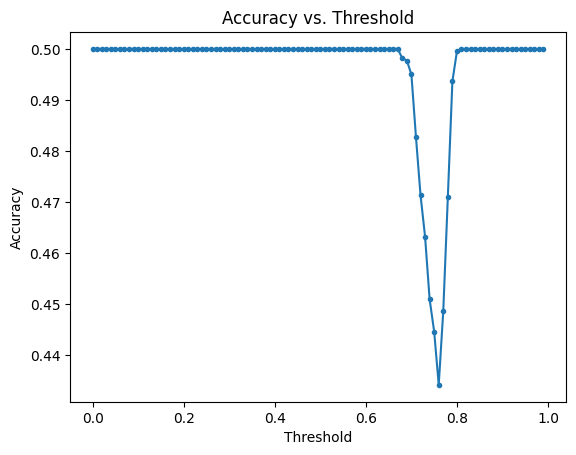

In [ ]:
# Plot a precision recall curve on the test set
import matplotlib.pyplot as plt

# predict probabilities
yhat = metrics['probs'][:, 1]
threshold_range = np.arange(0.0, 1.0, 0.01)
accuracies = []
f1s = []
best_acc = 0
best_thresh = 0
for threshold in threshold_range:
    yhat_thresh = (yhat > threshold).astype(int)
    accuracies.append(np.mean(yhat_thresh == metrics['labels']))
    f1s.append(sklearn.metrics.f1_score(metrics['labels'], yhat_thresh))
# Plot
plt.plot(threshold_range, accuracies, marker='.')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
table = wandb.Table(data=list(zip(threshold_range, accuracies)), columns=["threshold", "accuracy"])
wandb.log({'accuracy_vs_threshold': wandb.plot.line(table, "threshold", "accuracy", title="Accuracy vs. Threshold")})
tablef1 = wandb.Table(data=list(zip(threshold_range, f1s)), columns=["threshold", "f1"])
wandb.log({'f1_vs_threshold': wandb.plot.line(table, "threshold", "f1", title="Unweighted F1 vs. Threshold")})

Best threshold: 0.0
Best accuracy: 0.5


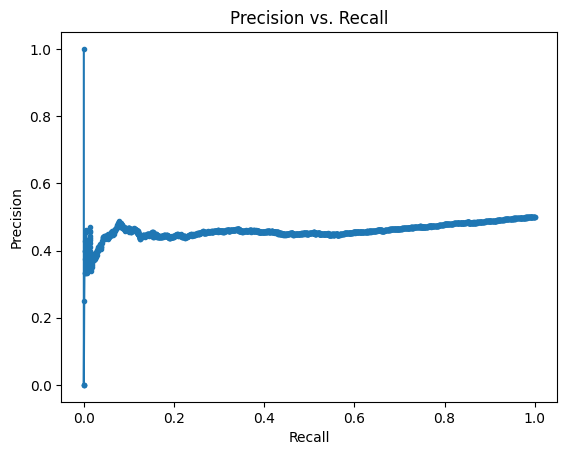

In [ ]:
# print best threshold
best_thresh = threshold_range[np.argmax(accuracies)]
print(f"Best threshold: {best_thresh}")
print(f"Best accuracy: {np.max(accuracies)}")

# Then plot the precision recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(metrics['labels'], yhat)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
table = wandb.Table(data=list(zip(recall, precision)), columns=["recall", "precision"])
wandb.log({'precision_vs_recall': wandb.plot.line(table, "recall", "precision", title="Precision vs. Recall")})

In [ ]:
print('Evaluating on additional test sets')
for path in ADDITIONAL_TEST_FILES:
    folder = os.path.dirname(path)
    ensure_data_folder(folder)
    test_language = 'py' if 'python' in path.lower() else 'go' if 'go' in path.lower() else 'js' if 'js' in path.lower() else 'java'
    print(f'Loaded test set for {test_language} from {path}')
    new_data_raw, new_dataset = dataset_from_file(path, MODEL_TYPE, tokenizer, MAX_LENGTH)
    new_dataloader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    metrics = compute_model_metrics(my_model, new_dataloader, language=test_language, positive_threshold=best_val_positive_threshold)
    print(f'Results on {path}:')
    print(f'Test loss: {metrics["loss"]}, accuracy: {metrics["acc"]}, F1: {metrics["f1"]}, precision: {metrics["precision"]}, weighted f1: {metrics["weighted_f1"]} at threshold {metrics["positive_threshold"]}')
    if USE_WANDB:
        log_prefix = path.replace('.json', '').replace('data/', '')
        wandb.log({log_prefix + '_' + k: metrics[k] for k in METRICS_KEYS})
    cm = metrics['confusion']
    print('Confusion matrix of test set')
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print(f"false positives: {fp}, false negatives: {fn}")

Evaluating on additional test sets


In [ ]:
# Perform post-hoc evaluation, train threshold on validation set and then evaluate on test set
# works by getting score for old comment + old code, and then old comment + new code
# decide whether old comment is positive now by comparing scores with threshold

from data import CustomPostHocDataset, get_posthoc_collate_fn

posthoc_collate_fn = get_posthoc_collate_fn(tokenizer)

# First create the validation CustomPostHocDataset
# TODO: use valid
val_posthoc_dataset = CustomPostHocDataset('{}/test.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
val_posthoc_dataloader = DataLoader(val_posthoc_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=posthoc_collate_fn)

def evaluate_posthoc(dataloader):
    my_model.eval()
    # Store the positive label scores as a list of tuples (old_score, new_score, label)
    all_posthoc_scores = []
    # Ask the model for predictions on the old and new cases of the validation set
    for batch in tqdm(dataloader):
        old_input_ids, old_attention_mask, new_input_ids, new_attention_mask, labels, _ = batch
        if torch.cuda.is_available():
            old_input_ids = old_input_ids.cuda()
            old_attention_mask = old_attention_mask.cuda()
            new_input_ids = new_input_ids.cuda()
            new_attention_mask = new_attention_mask.cuda()
            labels = labels.cuda()
        with torch.no_grad():
            old_probs = my_model(old_input_ids, old_attention_mask, labels)[0]
            new_probs = my_model(new_input_ids, new_attention_mask, labels)[0]
        for old, new, label in zip(old_probs, new_probs, labels):
            # Store the scores for the positive label
            all_posthoc_scores.append((old[1].item(), new[1].item(), label.item()))
    return all_posthoc_scores

val_posthoc_scores = evaluate_posthoc(val_posthoc_dataloader)

Loading 2200 examples from data/JS-22k/valid.json


100%|██████████| 2200/2200 [00:01<00:00, 1131.64it/s]


Total number of tokens: 281600
Total number of truncated examples: 1282
Total number of input tokens (ignoring truncation): 227131
Mean: 103.24136363636363
Median: 128.0
Standard deviation: 34.90503243157907
Minimum: 20
Maximum: 128
Loading 2200 examples from data/JS-22k/valid.json


100%|██████████| 2200/2200 [00:02<00:00, 1011.84it/s]


Total number of tokens: 281600
Total number of truncated examples: 1257
Total number of input tokens (ignoring truncation): 226489
Mean: 102.94954545454546
Median: 128.0
Standard deviation: 34.61118710071443
Minimum: 17
Maximum: 128
Loading 2200 examples from data/JS-22k/valid.json


100%|██████████| 2200/2200 [00:01<00:00, 1123.68it/s]


Total number of tokens: 281600
Total number of truncated examples: 1282
Total number of input tokens (ignoring truncation): 227131
Mean: 103.24136363636363
Median: 128.0
Standard deviation: 34.90503243157907
Minimum: 20
Maximum: 128


100%|██████████| 734/734 [20:23<00:00,  1.67s/it]


Best cutoff: 0.008000000000000895
Best accuracy: 0.5504545454545454


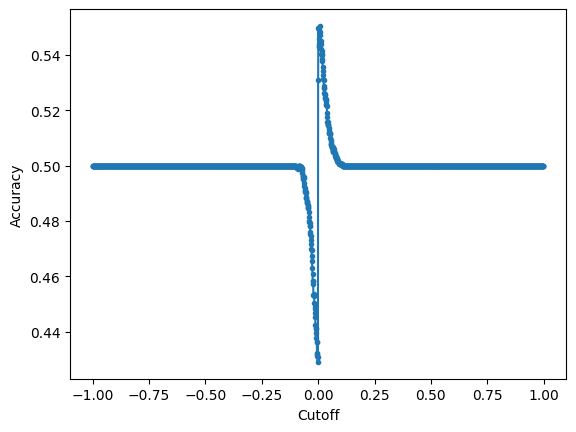

In [ ]:
# Find the cutoff that maximizes accuracy: i.e. we predict 1 if new - old > cutoff and 0 otherwise

# Sort by the score difference
score_differences = sorted([(new - old, label) for old, new, label in val_posthoc_scores], key=lambda x: x[0], reverse=True)
# Find the cutoff that maximizes accuracy
accs = []
cutoffs = np.arange(-1, 1, 0.001)
for cutoff in cutoffs:
    yhat = np.array([1 if diff > cutoff else 0 for diff, _ in score_differences])
    acc = np.mean(yhat == np.array([label for _, label in score_differences]))
    accs.append(acc)

# Create plot
plt.plot(cutoffs, accs, marker='.')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
table = wandb.Table(data=list(zip(cutoffs, accs)), columns=["cutoff", "accuracy"])
wandb.log({'accuracy_vs_cutoff': wandb.plot.line(table, "cutoff", "accuracy", title="Accuracy vs. Cutoff")})

# print best threshold
best_cutoff = cutoffs[np.argmax(accs)]
print(f"Best cutoff: {best_cutoff}")
print(f"Best accuracy: {np.max(accs)}")
# Log to wandb
if USE_WANDB:
    wandb.log({'posthoc_best_cutoff': best_cutoff, 'posthoc_best_acc': np.max(accs)})

In [ ]:
# Evaluate best_cutoff on test set
test_posthoc_dataset = CustomPostHocDataset('{}/test.json'.format(DATA_FOLDER), MODEL_TYPE, tokenizer, MAX_LENGTH)
test_posthoc_dataloader = DataLoader(test_posthoc_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=posthoc_collate_fn)
test_posthoc_scores = evaluate_posthoc(test_posthoc_dataloader)

# Evaluate the model on the test set
yhat = np.array([1 if new - old > best_cutoff else 0 for old, new, _ in test_posthoc_scores])
y = np.array([label for _, _, label in test_posthoc_scores])
acc = sklearn.metrics.accuracy_score(y, yhat)
f1 = sklearn.metrics.f1_score(y, yhat)
precision = sklearn.metrics.precision_score(y, yhat)
recall = sklearn.metrics.recall_score(y, yhat)
confusion = sklearn.metrics.confusion_matrix(y, yhat)

print(f"Test accuracy: {acc}")
print(f"Test F1: {f1}")
print(f"Test precision: {precision}")
print(f"Test recall: {recall}")
print(f"Test confusion matrix:")
print(confusion)
print('Confusion matrix of test set')
tn, fp, fn, tp = confusion.ravel()
print(f"false positives: {fp}, false negatives: {fn}")
# Log to wandb
if USE_WANDB:
    wandb.log({
        'posthoc_test_acc': acc,
        'posthoc_test_f1': f1,
        'posthoc_test_precision': precision,
        'posthoc_test_recall': recall,
    })


Loading 2200 examples from data/JS-22k/test.json


100%|██████████| 2200/2200 [00:01<00:00, 1102.38it/s]


Total number of tokens: 281600
Total number of truncated examples: 1333
Total number of input tokens (ignoring truncation): 233651
Mean: 106.205
Median: 128.0
Standard deviation: 32.21301646144699
Minimum: 20
Maximum: 128
Loading 2200 examples from data/JS-22k/test.json


100%|██████████| 2200/2200 [00:02<00:00, 1000.04it/s]


Total number of tokens: 281600
Total number of truncated examples: 1282
Total number of input tokens (ignoring truncation): 232595
Mean: 105.725
Median: 128.0
Standard deviation: 32.41501212962346
Minimum: 12
Maximum: 128
Loading 2200 examples from data/JS-22k/test.json


100%|██████████| 2200/2200 [00:02<00:00, 1087.13it/s]


Total number of tokens: 281600
Total number of truncated examples: 1333
Total number of input tokens (ignoring truncation): 233651
Mean: 106.205
Median: 128.0
Standard deviation: 32.21301646144699
Minimum: 20
Maximum: 128


 54%|█████▍    | 400/734 [11:11<09:20,  1.68s/it]


KeyboardInterrupt: 

In [ ]:
wandb.finish()
print('Done!')

Done!
